In [1]:
import albumentations as A
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Example Image

(-0.5, 499.5, 374.5, -0.5)

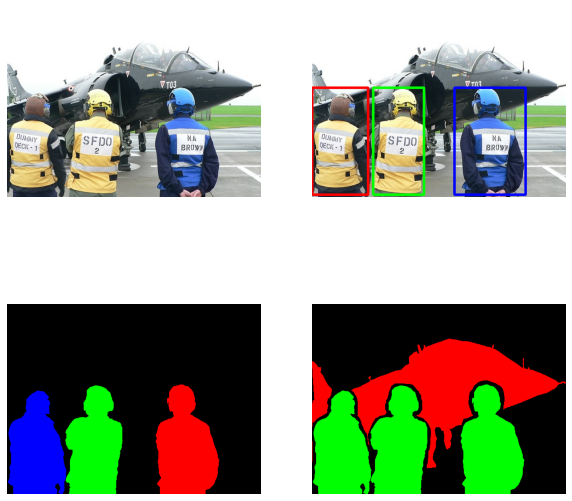

In [2]:
image1 = Image.open('example_image.jpg')
image1 = np.array(image1)

image2 = image1.copy()
bboxes = [[0,160,110,370],[120,160,220,370],[280,160,420,370]]
cv2.rectangle(image2, (0,160), (110,370), color=(255,0,0), thickness=3)
cv2.rectangle(image2, (120,160), (220,370), color=(0,255,0), thickness=3)
cv2.rectangle(image2, (280,160), (420,370), color=(0,0,255), thickness=3)

mask1 = Image.open('example_mask1.png')
mask1 = np.array(mask1)
mask_red = np.where(mask1 == 1, 255, np.zeros_like(mask1))
mask_green = np.where(mask1 == 2, 255, np.zeros_like(mask1))
mask_blue = np.where(mask1 == 3, 255, np.zeros_like(mask1))
mask1 = np.stack([mask_red, mask_green, mask_blue], axis=2)

mask2 = Image.open('example_mask2.png')
mask2 = np.array(mask2)
mask_red = np.where(mask2 == 1, 255, np.zeros_like(mask2))
mask_green = np.where(mask2 == 15, 255, np.zeros_like(mask2))
mask2 = np.stack([mask_red, mask_green, np.zeros_like(mask2)], axis=2)

plt.figure(figsize=(10,10))
plt.subplot(2,2,1); plt.imshow(image1); plt.axis('off')
plt.subplot(2,2,2); plt.imshow(image2); plt.axis('off')
plt.subplot(2,2,3); plt.imshow(mask1); plt.axis('off')
plt.subplot(2,2,4); plt.imshow(mask2); plt.axis('off')

# 1. Classification

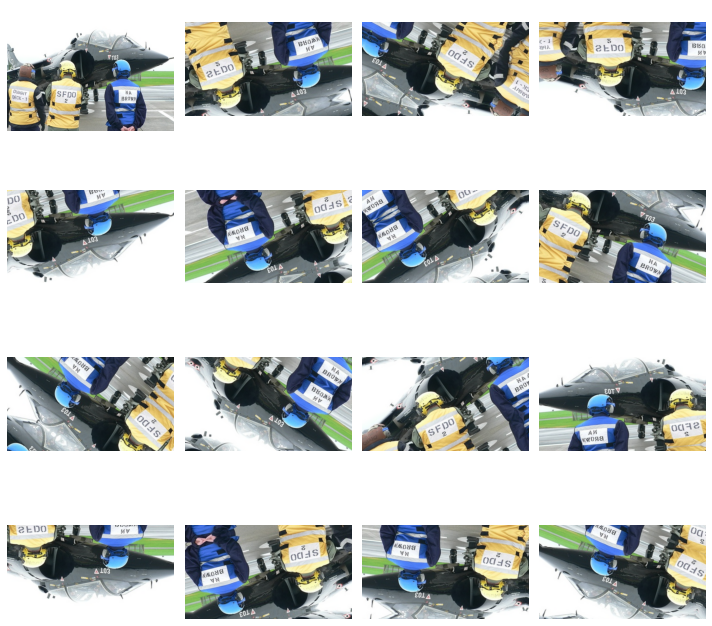

In [4]:
transform = A.Compose([
    A.Resize(width=1920, height=1080),
    A.RandomCrop(width=1280, height=720),
    A.Rotate(limit=40,p=0.9),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
])

image_list = [image1]
for i in range(15):
    augmentations = transform(image=image1)
    augmented_img = augmentations['image']
    image_list.append(augmented_img)
    
fig, axes = plt.subplots(4,4, figsize=(10,10))
axes = axes.ravel()
for i, img in enumerate(image_list):
    axes[i].imshow(image_list[i])
    axes[i].axis('off')
    
plt.tight_layout()

# 2. Detection

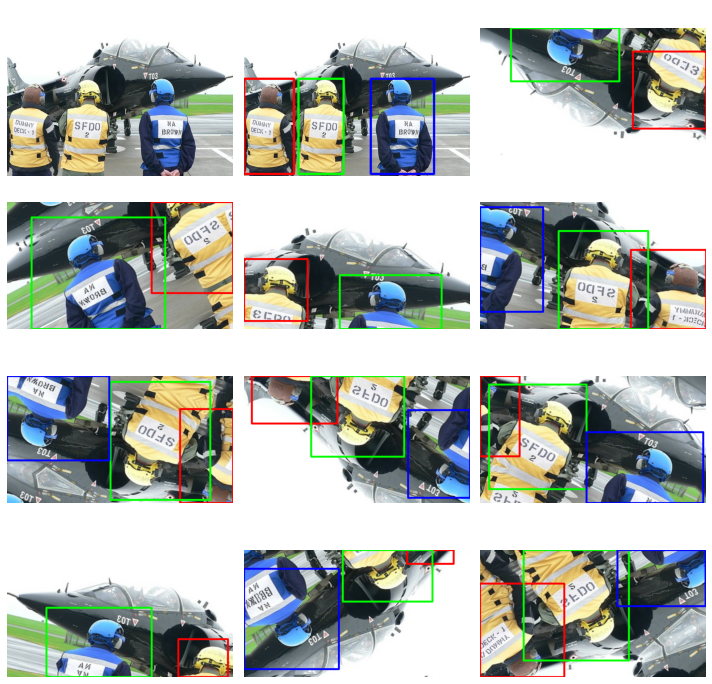

In [35]:
transform = A.Compose([
    A.Resize(width=1920, height=1080),
    A.RandomCrop(width=1280, height=720),
    A.Rotate(limit=40,p=0.9),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=[]))

image_list = [image1, image2]
saved_bboxes = [bboxes[0], bboxes[1], bboxes[2]]
for i in range(10):
    augmentations = transform(image=image1, bboxes=bboxes)
    augmented_img = augmentations['image']
    bxs = augmentations['bboxes']
    bxs = [tuple(list(map(int, b))) for b in bxs]
    
    new_image = augmented_img.copy()
    colors = [(255,0,0), (0,255,0), (0,0,255)]
    for j in range(len(bxs)):      
        cv2.rectangle(new_image, bxs[j][:2], bxs[j][2:], color=colors[j], thickness=10)
    image_list.append(new_image)
    
fig, axes = plt.subplots(4,3, figsize=(10,10))
axes = axes.ravel()
for i, img in enumerate(image_list):
    axes[i].imshow(image_list[i])
    axes[i].axis('off')
    
plt.tight_layout()

# 3-1. Segmentation - single mask

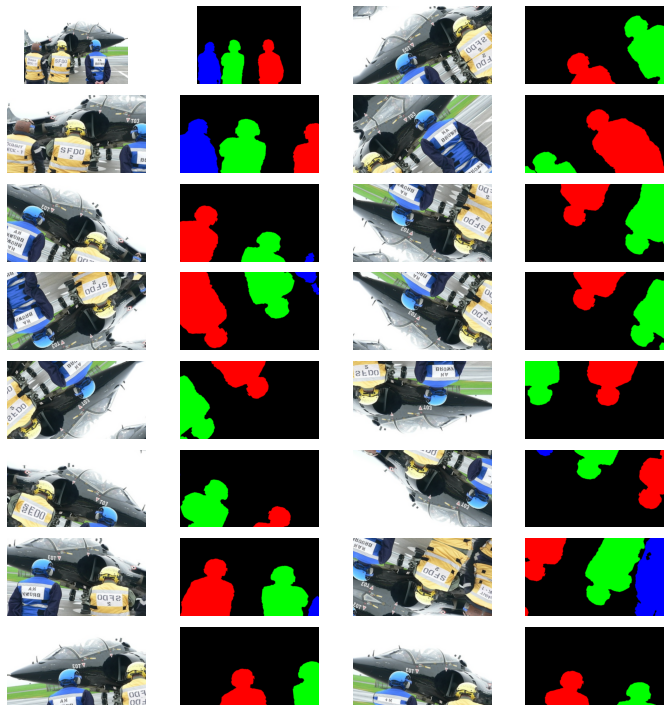

In [7]:
transform = A.Compose([
    A.Resize(width=1920, height=1080),
    A.RandomCrop(width=1280, height=720),
    A.Rotate(limit=40,p=0.9),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
])

image_list = [image, mask1]
for i in range(15):
    augmentations = transform(image=image, mask=mask1)
    augmented_img = augmentations['image']
    augmented_mask1 = augmentations['mask']
    image_list.append(augmented_img)
    image_list.append(augmented_mask1)
    
fig, axes = plt.subplots(8,4, figsize=(10,10))
axes = axes.ravel()
for i, img in enumerate(image_list):
    axes[i].imshow(image_list[i])
    axes[i].axis('off')
    
plt.tight_layout()

# 3-2. Segmentation - multi mask

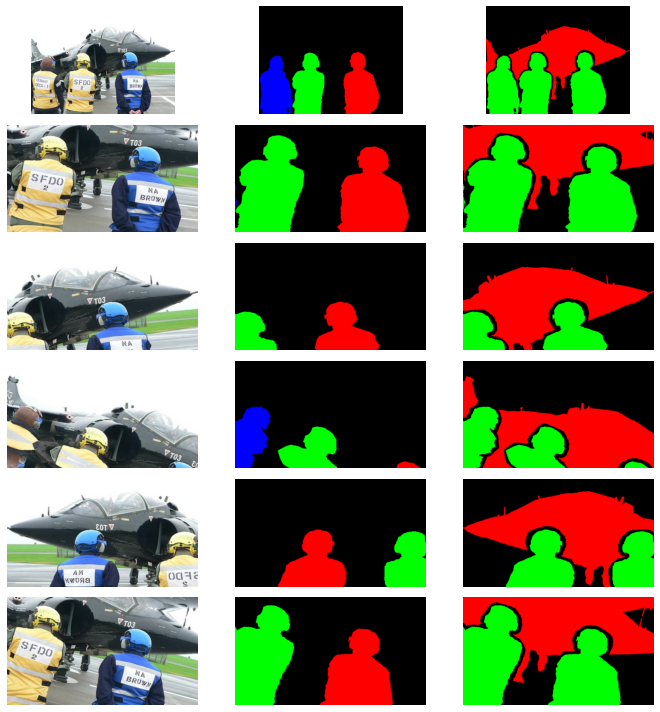

In [9]:
transform = A.Compose([
    A.Resize(width=1920, height=1080),
    A.RandomCrop(width=1280, height=720),
    A.Rotate(limit=40,p=0.9),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
])

image_list = [image, mask1, mask2]
for i in range(5):
    augmentations = transform(image=image, masks=[mask1, mask2])
    augmented_img = augmentations['image']
    augmented_masks = augmentations['masks']
    image_list.append(augmented_img)
    image_list.append(augmented_masks[0])
    image_list.append(augmented_masks[1])
    
fig, axes = plt.subplots(6,3, figsize=(10,10))
axes = axes.ravel()
for i, img in enumerate(image_list):
    axes[i].imshow(image_list[i])
    axes[i].axis('off')
    
plt.tight_layout()

# Pytorch

In [38]:
import os

import torch
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [56]:
class CatDogDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        super(CatDogDataset, self).__init__()
        self.data = []
        self.root_dir = root_dir
        self.class_names = os.listdir(self.root_dir)
        self.transform = transform
        
        for index, name in enumerate(self.class_names):
            file_names = os.listdir(os.path.join(self.root_dir, name))
            self.data += list(zip(file_names, [index]*len(file_names)))
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        file_name, label = self.data[idx]
        image_path = os.path.join(self.root_dir, self.class_names[label], file_name)
        
        image = np.array(Image.open(image_path))
        
        
        if self.transform is not None:
            augmentations = self.transform(image=image)
            image = augmentations['image']
        
        return image, label

In [60]:
transform = A.Compose([
    A.Resize(width=1920, height=1080),
    A.RandomCrop(width=1280, height=720),
    A.Rotate(limit=40,p=0.9),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=[0,0,0], std=[1,1,1]),
    ToTensorV2()
])

data_path = r'C:\Users\gjust\Documents\Github\data\dogs-vs-cats\train'
mydataset = CatDogDataset(data_path, transform=transform)

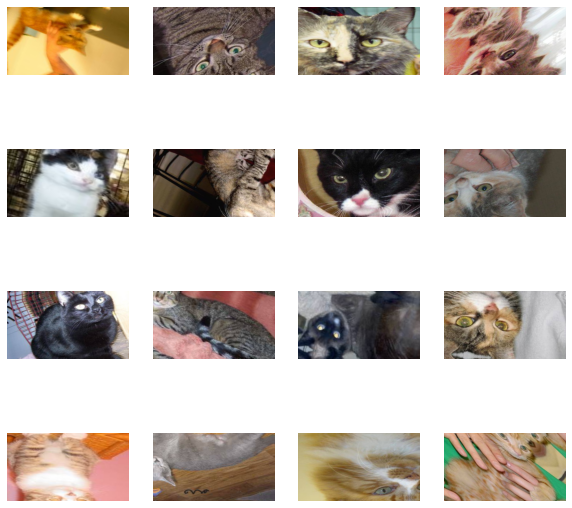

In [64]:
plt.figure(figsize=(10,10))
for i, (x, y) in enumerate(mydataset):
    if i == 16:
        break
    plt.subplot(4,4,i+1); plt.imshow(np.array(x.permute(1,2,0))); plt.axis('off')